In [3]:
from itertools import chain, zip_longest
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

## Load Data

In [5]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

## Probability Density Function for a Normal Distribution

In [6]:
def compute_prob_density(x, axis=0):
    mean, std = np.mean(np.array(x), axis=axis), np.std(np.array(x), axis=axis)
    return lambda x: np.exp(-0.5*((x - mean)/std)**2)/(std*np.sqrt(2*np.pi)) 

## Numeric Integrator

In [7]:
def euler(x0=0, dt=0, dy=0, steps=-1, thr=1e-3):
    steps = int(thr/dt) if steps < 1 else steps
    value = np.zeros_like(x0)
    for step in range(steps):
        x0 = x0 + dt
        value = value + dt*dy(x0)

    return value

## Class Conditional Probability Function
Computes the PDF (Probability Density) and integrates over an interval $x_i + \Delta_x$ to approximate the conditonal probability $P(x_i | w_j)$

In [8]:
def compute_probability(feature, thr=1e-3, integrate=True):
    if integrate:
        return lambda x: euler(x0=x, dy=compute_prob_density(feature), dt=1e-5, thr=thr)
    
    return lambda x: compute_prob_density(feature)(x)

## Example

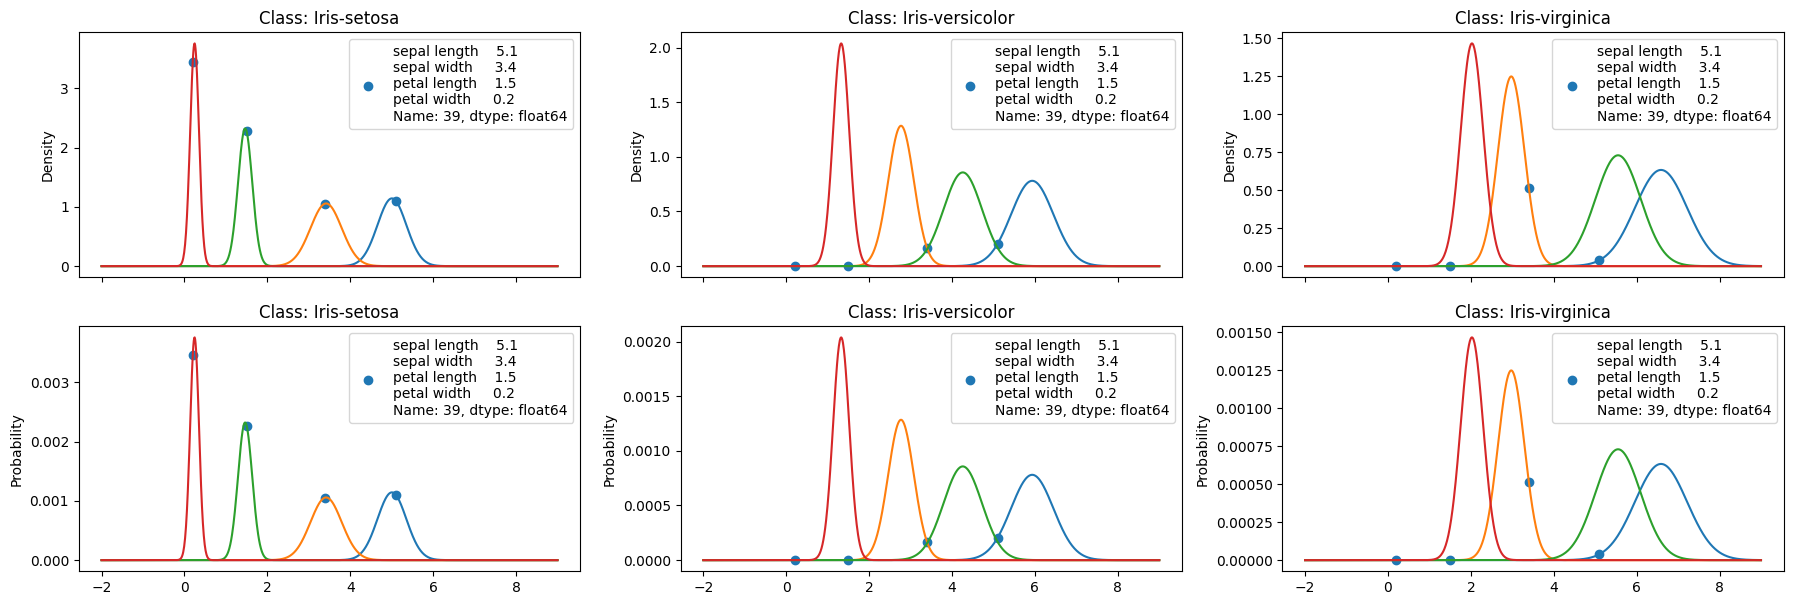

In [9]:
from code.src.utils import visualize_prob_distribution
visualize_prob_distribution(x=X, y=y)

## Naive Bayes Classifier

In [10]:
class NaiveBayes:
    def __init__(self, integrate=True):
        self.integrate = integrate
        self.classes = None
        self.indices = None
        self.class_conditionals = None
        self.class_probabilities = None
        self._probabilities = None
        self._fitted = False
        self._prob_dist = {}
    
    @property
    def probabilities(self):
        prob = pd.concat(self._probabilities, axis=1)
        prob.columns = self.classes
        return prob
    
    def _class_conditionals(self, x, c):
        func = self._prob_dist[c] 
        class_conditionals =  np.prod(func(x), axis=1) * self.class_probabilities[c]
        class_conditionals /= np.sum(class_conditionals) # compute conditional probability for each sample by dividing by the sum of samples
        return class_conditionals
        
    def predict(self, x):
        probabilities = []
        if not self._fitted:
            for i, (c, class_indices) in enumerate(zip(self.classes, self.indices)):
                # Create and fit a probability function to each class  
                self._prob_dist[c] = compute_probability(feature=x.iloc[class_indices], thr=1e-3, integrate=self.integrate)   
                probabilities.append(self._class_conditionals(x=x, c=c)) # compute and store the class_conditionals P(y | X) 
                
            self._fitted = True
        else:
            for i, c in enumerate(self.classes):
                probabilities.append(self._class_conditionals(x=x, c=c)) # store probabilities
                

        self._probabilities = probabilities
        return  [self.classes[_] for _ in np.argmax(pd.DataFrame(np.array(probabilities).transpose(), columns=self.classes), axis=1)]
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):        
        if not isinstance(x, pd.DataFrame):
            x = pd.DataFrame(x)
            
        if isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y)
        
        # Compute the prior for the class probabilities P(y)
        self.class_probabilities = y.value_counts()/len(y) 
        
        # Extract the classes
        self.classes = list(chain(*self.class_probabilities.index))
        
        # Extract indices
        self.indices = list(y.groupby(list(y.columns)).groups.values())
        
        return self.predict(x=x)

## Example

In [11]:
from code.src.bdt import NaiveBayes

In [12]:
nb = NaiveBayes()
pred = nb.fit(x=X, y=y)
res = pd.concat([X, y, pd.DataFrame(pred), pd.DataFrame([int(t[0] == p) for t, p in zip(y.values, pred)])], axis=1)
res.columns = [*list(res.columns[:-3]), 'actual', 'pred', 'accurate']
print(f'accuracy: {round(res.accurate.mean(), 2)}')

accuracy: 0.95


## Plots

In [13]:
from code.src.utils import visualize_decision_boundary
from code.src.utils import visualize_confusion_matrix
from code.src.utils import compute_metric_table

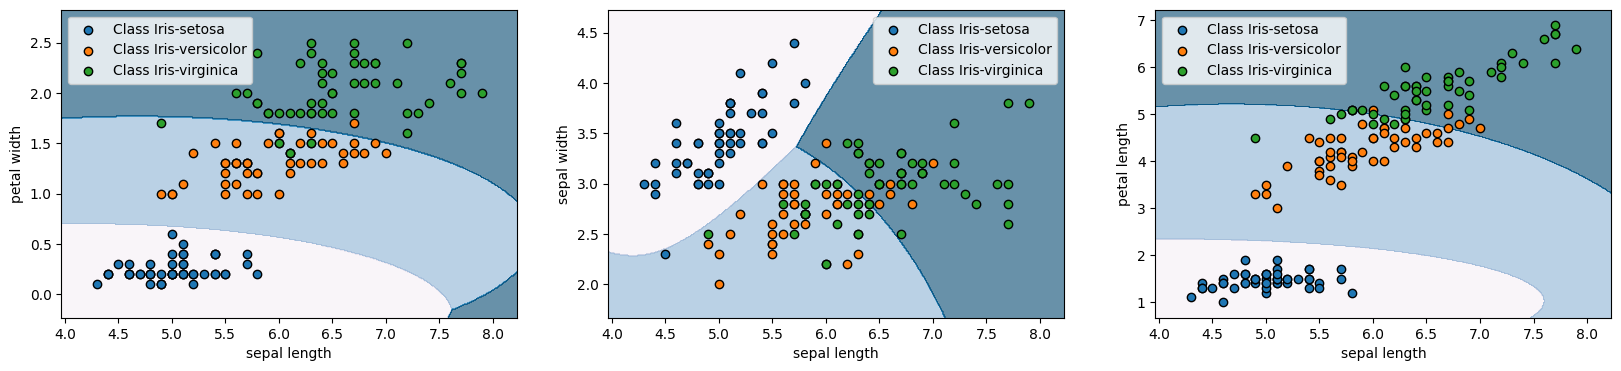

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for i, ax in enumerate(axes):
    i = 3 if i == 0 else i
    visualize_decision_boundary(x=X.iloc[:, [0, i]], y=y, predictor=lambda : NaiveBayes(integrate=False), cmap=plt.cm.PuBu, ax=ax)

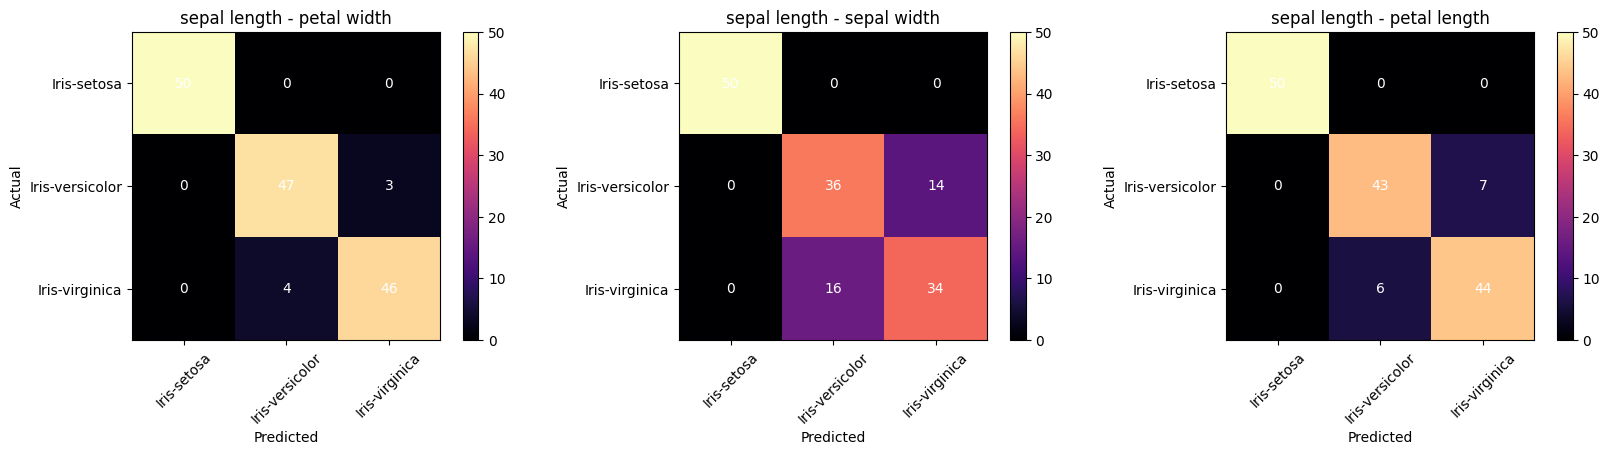

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
origin = 0
for i, ax in enumerate(axes):
    i = 3 if i == origin else i
    ft = X.iloc[:, [origin, i]]
    visualize_confusion_matrix(pred=NaiveBayes(integrate=False).fit(ft, y=y), y=y, ax=ax, title=f'{ft.iloc[:, 0].name} - {ft.iloc[:, 1].name}')

In [16]:
compute_metric_table(y_true=y, y_pred=pred)

,precision,recall,f1
Iris-setosa,1.000000,1.00,1.000000
Iris-versicolor,0.937500,0.90,0.918367
Iris-virginica,0.903846,0.94,0.921569
